# Why Not LayerNorm? RMSNorm vs LayerNorm

This notebook compares two normalization methods in the same Pre-Norm GPT architecture:

| Method | Formula | Learnable Params | Used By |
|--------|---------|------------------|---------|
| **RMSNorm** | `x / sqrt(mean(x²) + ε) * scale` | `scale` only | LLaMA, Gemma, Step 3 |
| **LayerNorm** | `(x - mean(x)) / sqrt(var(x) + ε) * scale + bias` | `scale` + `bias` | GPT-2, BERT, original Transformer |

**Key paper**: [Root Mean Square Layer Normalization](https://arxiv.org/abs/1910.07467) (Zhang & Sennrich 2019)

In [1]:
import subprocess, sys, json
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 12

## 1. Run Experiments

In [2]:
print("Running RMSNorm and LayerNorm experiments...")
proc = subprocess.run([sys.executable, 'main.py'], capture_output=True, text=True, timeout=300)
print(proc.stdout)
if proc.returncode != 0:
    print("STDERR:", proc.stderr[-500:])

Running RMSNorm and LayerNorm experiments...


num docs: 32033
vocab size: 27

  Experiment: RMSNorm
  params: 4240
  step    1/1000 | loss 3.4034
  step    2/1000 | loss 3.8509
  step    3/1000 | loss 3.3831
  step    4/1000 | loss 3.7779
  step    5/1000 | loss 3.1347
  step    6/1000 | loss 3.4468
  step    7/1000 | loss 3.2040
  step    8/1000 | loss 3.4899
  step    9/1000 | loss 3.0884
  step   10/1000 | loss 3.1397
  step  100/1000 | loss 3.2288
  step  200/1000 | loss 2.3490
  step  300/1000 | loss 2.2838
  step  400/1000 | loss 2.5728
  step  500/1000 | loss 2.1964
  step  600/1000 | loss 2.5036
  step  700/1000 | loss 2.4467
  step  800/1000 | loss 2.4096
  step  900/1000 | loss 2.7908
  step 1000/1000 | loss 2.5224
  total training time: 0.78s
  samples: mann, kaylan, irilan, staile, janan ...

  Experiment: LayerNorm
  params: 4288
  step    1/1000 | loss 3.4512
  step    2/1000 | loss 3.8073
  step    3/1000 | loss 3.3683
  step    4/1000 | loss 3.8586
  step    5/1000 | loss 3.2107
  step    6/1000 | loss 3.4960
  ste

## 2. Load Results

In [3]:
with open('results_rmsnorm.json') as f:
    rms = json.load(f)
with open('results_layernorm.json') as f:
    ln = json.load(f)

configs = [
    ('RMSNorm', rms, 'tab:green'),
    ('LayerNorm', ln, 'tab:purple'),
]

for name, res, _ in configs:
    losses = [e['loss'] for e in res['loss_log']]
    times = [e['time'] for e in res['loss_log']]
    print(f"{name:>10}: {res['num_params']} params | avg last 100: {np.mean(losses[-100:]):.4f} | {np.mean(times)*1000:.3f}ms/step")

   RMSNorm: 4240 params | avg last 100: 2.3250 | 0.778ms/step
 LayerNorm: 4288 params | avg last 100: 2.3286 | 0.824ms/step


## 3. Loss Curves

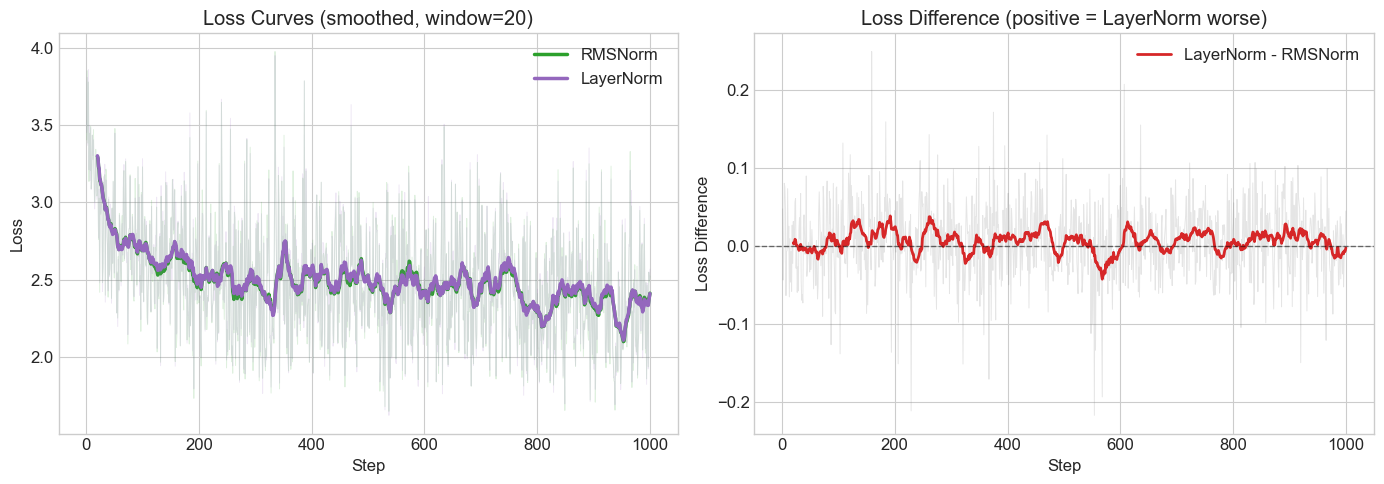

Saved: loss_curves.png


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

window = 20

# Left: full loss curves
for name, res, color in configs:
    steps = [e['step'] for e in res['loss_log']]
    losses = [e['loss'] for e in res['loss_log']]
    axes[0].plot(steps, losses, alpha=0.15, linewidth=0.7, color=color)
    if len(losses) >= window:
        smooth = np.convolve(losses, np.ones(window)/window, mode='valid')
        axes[0].plot(steps[window-1:], smooth, linewidth=2.5, color=color, label=name)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves (smoothed, window=20)')
axes[0].legend(fontsize=12)

# Right: loss difference (LayerNorm - RMSNorm)
rms_losses = [e['loss'] for e in rms['loss_log']]
ln_losses = [e['loss'] for e in ln['loss_log']]
diff = np.array(ln_losses) - np.array(rms_losses)
steps = [e['step'] for e in rms['loss_log']]

axes[1].plot(steps, diff, alpha=0.2, linewidth=0.7, color='gray')
if len(diff) >= window:
    smooth_diff = np.convolve(diff, np.ones(window)/window, mode='valid')
    axes[1].plot(steps[window-1:], smooth_diff, linewidth=2, color='tab:red', label='LayerNorm - RMSNorm')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Loss Difference')
axes[1].set_title('Loss Difference (positive = LayerNorm worse)')
axes[1].legend(fontsize=12)

plt.tight_layout()
plt.savefig('loss_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: loss_curves.png")

## 4. Per-Step Timing

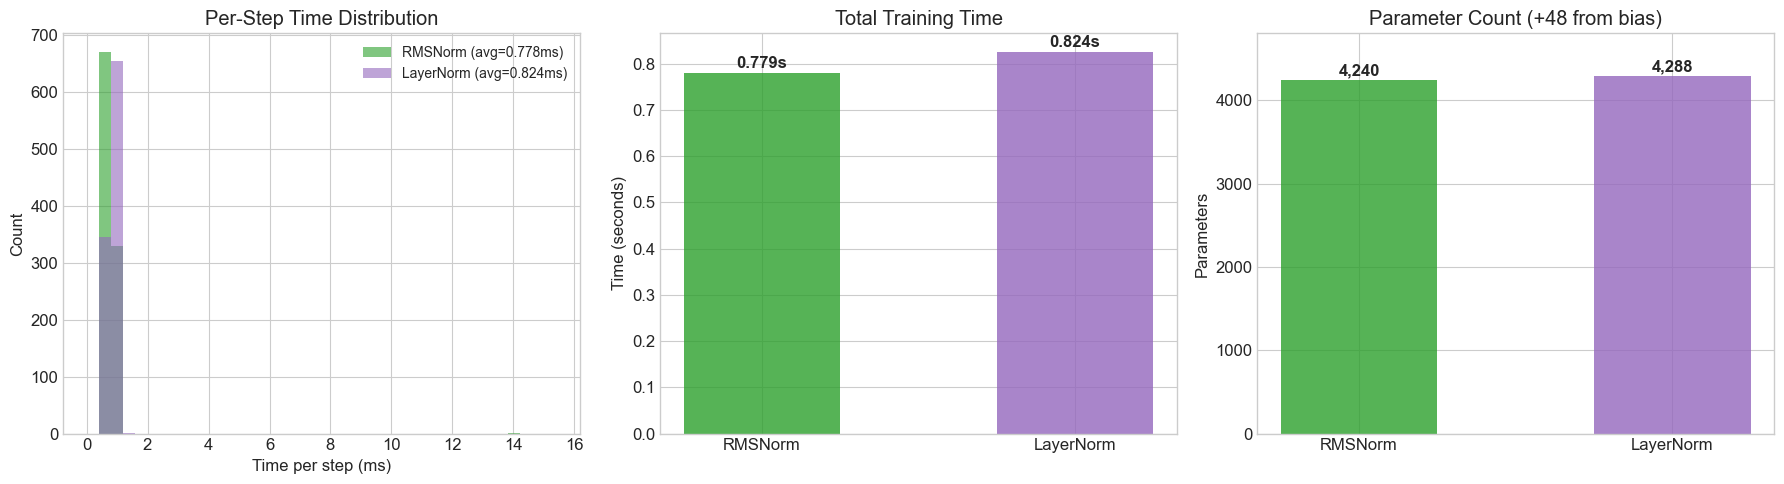

Saved: time_comparison.png


In [5]:
rms_times = [e['time'] * 1000 for e in rms['loss_log']]  # ms
ln_times = [e['time'] * 1000 for e in ln['loss_log']]

rms_avg = np.mean(rms_times)
ln_avg = np.mean(ln_times)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Left: histograms
bins = np.linspace(0, max(max(rms_times), max(ln_times)) * 1.1, 40)
axes[0].hist(rms_times, bins=bins, alpha=0.6, color='tab:green', label=f'RMSNorm (avg={rms_avg:.3f}ms)')
axes[0].hist(ln_times, bins=bins, alpha=0.6, color='tab:purple', label=f'LayerNorm (avg={ln_avg:.3f}ms)')
axes[0].set_xlabel('Time per step (ms)')
axes[0].set_ylabel('Count')
axes[0].set_title('Per-Step Time Distribution')
axes[0].legend(fontsize=10)

# Middle: total training time
labels = ['RMSNorm', 'LayerNorm']
colors = ['tab:green', 'tab:purple']
times_total = [rms['total_train_time'], ln['total_train_time']]
bars = axes[1].bar(labels, times_total, color=colors, width=0.5, alpha=0.8)
for bar, t in zip(bars, times_total):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{t:.3f}s', ha='center', va='bottom', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Total Training Time')

# Right: parameter count
params = [rms['num_params'], ln['num_params']]
bars = axes[2].bar(labels, params, color=colors, width=0.5, alpha=0.8)
for bar, p in zip(bars, params):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                 f'{p:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Parameters')
axes[2].set_title(f'Parameter Count (+{ln["num_params"] - rms["num_params"]} from bias)')
axes[2].set_ylim(0, max(params) * 1.12)

plt.tight_layout()
plt.savefig('time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: time_comparison.png")

## 5. Summary Table

In [6]:
rms_l = [e['loss'] for e in rms['loss_log']]
ln_l = [e['loss'] for e in ln['loss_log']]

print("=" * 60)
print(f"{'Metric':<30} {'RMSNorm':>13} {'LayerNorm':>13}")
print("=" * 60)
print(f"{'Parameters':.<30} {rms['num_params']:>13,} {ln['num_params']:>13,}")
print(f"{'  - Norm params':.<30} {'scale only':>13} {'scale + bias':>13}")
print(f"{'  - Extra from bias':.<30} {'—':>13} {f'+{ln["num_params"] - rms["num_params"]}':>13}")
print(f"{'Avg loss (last 100)':.<30} {np.mean(rms_l[-100:]):>13.4f} {np.mean(ln_l[-100:]):>13.4f}")
print(f"{'Min loss':.<30} {min(rms_l):>13.4f} {min(ln_l):>13.4f}")
print(f"{'Avg step time':.<30} {rms_avg:>12.3f}ms {ln_avg:>12.3f}ms")
print(f"{'Total train time':.<30} {rms['total_train_time']:>12.3f}s {ln['total_train_time']:>12.3f}s")
overhead_pct = (ln['total_train_time'] - rms['total_train_time']) / rms['total_train_time'] * 100
print(f"{'LayerNorm overhead':.<30} {'':>13} {f'+{overhead_pct:.1f}%':>13}")
print("=" * 60)

Metric                               RMSNorm     LayerNorm
Parameters....................         4,240         4,288
  - Norm params...............    scale only  scale + bias
  - Extra from bias...........             —           +48
Avg loss (last 100)...........        2.3250        2.3286
Min loss......................        1.6476        1.6218
Avg step time.................        0.778ms        0.824ms
Total train time..............        0.779s        0.824s
LayerNorm overhead............                       +5.8%


## 6. Generated Samples

In [7]:
print(f"{'#':<4} {'RMSNorm':>20} {'LayerNorm':>20}")
print("-" * 46)
for i in range(20):
    r = rms['samples'][i] if i < len(rms['samples']) else ''
    l = ln['samples'][i] if i < len(ln['samples']) else ''
    print(f"{i+1:<4} {r:>20} {l:>20}")

print("\nBoth produce comparable quality — the difference is computational, not quality.")

#                 RMSNorm            LayerNorm
----------------------------------------------
1                    mann                 mann
2                  kaylan               kaylan
3                  irilan               iranna
4                  staile               stanan
5                   janan                janan
6                    dinn                 dian
7                    anir               aniron
8                    alan                 anen
9                    daya                karya
10                   onah               seerer
11                  erere                masan
12                mabyely                jayne
13                  jelia                karen
14                  kayir                arien
15                  abana                alana
16                 tarion               gorinu
17                  aurer                saris
18                  annen               jaryon
19                 loryir                 saya
20           

## 7. What's the Actual Difference?

```
LayerNorm                                 RMSNorm
─────────                                 ───────
x = [x₁, x₂, ..., xₙ]                   x = [x₁, x₂, ..., xₙ]
                                          
μ = mean(x)          ← compute mean       (skip)
x = x - μ            ← center to zero     (skip)
σ² = var(x)          ← compute variance   ms = mean(x²)   ← just mean of squares
x = x / √(σ² + ε)   ← normalize          x = x / √(ms + ε)
out = γ·x + β        ← scale + bias       out = γ·x       ← scale only
     ↑   ↑                                      ↑
   learned params (2n)                      learned params (n)
```

RMSNorm saves:
1. **One reduction** (no mean computation)
2. **One subtraction** (no centering)
3. **n parameters** (no bias vector)

At scale (billions of params, trillions of tokens), these savings add up significantly.